In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tqdm import tqdm
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the data
unbalanced_file = 'database/subset142.txt'
balanced_file = 'database/BalancedDatasetT.txt'

data = pd.read_csv(unbalanced_file, sep=';')
balanced_data = pd.read_csv(balanced_file, sep=';')

# Drop unnecessary columns
data = data.drop(['transformer_Location', 'ID', 'RATECLASS_DESC'], axis=1)
balanced_data = balanced_data.drop(['transformer_Location', 'ID', 'RATECLASS_DESC'], axis=1)

# Filter unlabeled data and combine with balanced data
unlabeled_data = data[data["# of Chargers"].isnull()]
combined_data = pd.concat([unlabeled_data, balanced_data], axis=0)

# Convert date to datetime
combined_data['YYYYMMDD'] = pd.to_datetime(combined_data['YYYYMMDD'], format='%Y%m%d')

# Convert YYYYMMDD to numerical features
combined_data['day_of_year'] = combined_data['YYYYMMDD'].dt.dayofyear / 365.0
combined_data['day_of_week'] = combined_data['YYYYMMDD'].dt.dayofweek / 6.0
combined_data['month'] = combined_data['YYYYMMDD'].dt.month / 12.0

# Display first few rows of the combined dataset
combined_data.head()

,YYYYMMDD,Location,# of Chargers,R1,R2,R3,R4,R5,R6,R7,...,R19,R20,R21,R22,R23,R24,Tx,day_of_year,day_of_week,month
0,2023-01-01,200,NaN,1.81,1.51,1.77,1.57,1.10,1.22,1.19,...,2.60,3.36,2.67,2.04,2.09,1.66,A122,0.002740,1.000000,0.083333
1,2023-01-02,200,NaN,1.87,1.66,1.31,1.15,1.00,0.89,0.83,...,1.62,2.32,5.80,1.63,1.34,0.88,A122,0.005479,0.000000,0.083333
2,2023-01-31,200,NaN,1.13,1.18,1.16,1.20,1.05,0.92,0.99,...,2.36,1.79,1.95,1.57,1.36,1.17,A122,0.084932,0.166667,0.083333
3,2023-01-03,200,NaN,0.83,0.99,0.96,0.86,0.85,0.80,0.88,...,2.03,2.10,1.98,1.76,1.39,0.92,A122,0.008219,0.166667,0.083333
4,2023-01-04,200,NaN,0.92,0.96,0.97,1.00,1.04,0.96,0.76,...,2.32,1.92,1.99,1.96,1.68,1.25,A122,0.010959,0.333333,0.083333


In [5]:
# Encode categorical variables
le_tx = LabelEncoder()
combined_data['Tx'] = le_tx.fit_transform(combined_data['Tx'])

# Prepare the features
feature_columns = ['day_of_year', 'day_of_week', 'month', 'Tx'] + [col for col in combined_data.columns if col.startswith('R')]

# Normalize the numerical features
scaler = MinMaxScaler()
numerical_features = [col for col in feature_columns if col.startswith('R')]
combined_data[numerical_features] = scaler.fit_transform(combined_data[numerical_features])

# Display the processed data
combined_data[feature_columns + ['# of Chargers']].head()

,day_of_year,day_of_week,month,Tx,R1,R2,R3,R4,R5,R6,...,R16,R17,R18,R19,R20,R21,R22,R23,R24,# of Chargers
0,0.002740,1.000000,0.083333,25,0.004159,0.003517,0.004148,0.003679,0.002597,0.001739,...,0.001604,0.001544,0.002080,0.002857,0.004174,0.003199,0.002705,0.003618,0.003664,NaN
1,0.005479,0.000000,0.083333,25,0.004297,0.003866,0.003070,0.002695,0.002361,0.001269,...,0.000983,0.001029,0.001736,0.001780,0.002882,0.006949,0.002161,0.002320,0.001942,NaN
2,0.084932,0.166667,0.083333,25,0.002597,0.002748,0.002718,0.002812,0.002479,0.001312,...,0.001604,0.001763,0.002368,0.002593,0.002223,0.002336,0.002082,0.002354,0.002582,NaN
3,0.008219,0.166667,0.083333,25,0.001907,0.002306,0.002250,0.002015,0.002007,0.001141,...,0.001638,0.001489,0.002046,0.002231,0.002609,0.002372,0.002333,0.002406,0.002031,NaN
4,0.010959,0.333333,0.083333,25,0.002114,0.002236,0.002273,0.002343,0.002455,0.001369,...,0.001514,0.001862,0.003069,0.002549,0.002385,0.002384,0.002599,0.002908,0.002759,NaN


In [7]:
# Create sequences
sequence_length = 24  # You can adjust this value
X = []
y = []

for location in combined_data['Location'].unique():
    location_data = combined_data[combined_data['Location'] == location].sort_values('YYYYMMDD')
    for i in range(len(location_data) - sequence_length):
        X.append(location_data.iloc[i:(i + sequence_length)][feature_columns].values)
        y.append(location_data.iloc[i + sequence_length]['# of Chargers'])

X = np.array(X)
y = np.array(y)



In [8]:
# Split into labeled and unlabeled data
labeled_mask = ~np.isnan(y)
X_labeled = X[labeled_mask]
y_labeled = y[labeled_mask]
X_unlabeled = X[~labeled_mask]

print("Shapes:")
print(f"X_labeled: {X_labeled.shape}")
print(f"y_labeled: {y_labeled.shape}")
print(f"X_unlabeled: {X_unlabeled.shape}")

Shapes:
X_labeled: (212628, 24, 28)
y_labeled: (212628,)
X_unlabeled: (48424, 24, 28)


In [9]:
# Create the model
input_shape = (X_labeled.shape[1], len(feature_columns))
num_tx_classes = len(le_tx.classes_)

inputs = Input(shape=input_shape)

# Separate inputs for numerical and categorical features
date_input = inputs[:, :, 0:3]  # day_of_year, day_of_week, month
tx_input = inputs[:, :, 3]      # Tx
numerical_input = inputs[:, :, 4:]  # R1-R24

# Embedding layer for Tx
tx_embedding = Embedding(num_tx_classes, 8)(tx_input)

# Process date input
date_features = TimeDistributed(Dense(8, activation='relu'))(date_input)

# LSTM layers for numerical features and date
combined_input = Concatenate()([date_features, numerical_input])
lstm_out = LSTM(64, return_sequences=True)(combined_input)
lstm_out = LSTM(32)(lstm_out)

# Concatenate LSTM output with Tx embedding
x = Concatenate()([lstm_out, tf.keras.layers.Flatten()(tx_embedding)])

x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 24, 28)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 24, 3)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 24, 8)             │              32 │ get_item[0][0]             │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 24, 24)            │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 24, 32)            │               0 │ time_distributed[0][0],    │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 24)                │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 24, 64)            │          24,832 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 24, 8)             │           4,864 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 32)                │          12,416 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 192)               │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 224)               │               0 │ lstm_1[0][0],              │
│                               │                           │                 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 16)                │           3,600 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              17 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,761 (178.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Semi-supervised training
n_iterations = 5
threshold = 0.8

X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

for iteration in range(n_iterations):
    # Train on labeled data
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

    # Predict on unlabeled data
    predictions = model.predict(X_unlabeled)
    
    # Select confident predictions
    confident_idx = np.abs(predictions - 0.5) > threshold
    new_X_labeled = X_unlabeled[confident_idx.flatten()]
    new_y_labeled = predictions[confident_idx]

    # Add to labeled dataset
    X_labeled = np.vstack((X_labeled, new_X_labeled))
    y_labeled = np.concatenate((y_labeled, new_y_labeled.flatten()))

    # Remove from unlabeled dataset
    X_unlabeled = X_unlabeled[~confident_idx.flatten()]

    print(f"Iteration {iteration + 1}: Added {len(new_X_labeled)} samples to labeled data")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

    # Update training data for next iteration
    X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

Epoch 1/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 112s 21ms/step - loss: 0.4491 - val_loss: 0.3946
Epoch 2/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 109s 21ms/step - loss: 0.4469 - val_loss: 0.3984
Epoch 3/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 113s 21ms/step - loss: 0.4388 - val_loss: 0.3965
Epoch 4/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 110s 21ms/step - loss: 0.4269 - val_loss: 0.4010
Epoch 5/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 110s 21ms/step - loss: 0.4318 - val_loss: 0.3919
Epoch 6/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 112s 21ms/step - loss: 0.4326 - val_loss: 0.3925
Epoch 7/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 111s 21ms/step - loss: 0.4339 - val_loss: 0.3918
Epoch 8/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 109s 20ms/step - loss: 0.4309 - val_loss: 0.3934
Epoch 9/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 109s 21ms/step - loss: 0.4211 - val_loss: 0.3910
Epoch 10/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 0.4338 - val_loss: 0.3905
Epoch 11/50
5316/5316 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 0.4157 - val_loss: 0.38

In [13]:
# Evaluate the model
X_test, y_test = X_val, y_val  # Using validation set for final evaluation
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_original = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), len(scaler.scale_) - 1)), y_pred], axis=1))[:, -1]
y_test_original = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(scaler.scale_) - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

mse = np.mean((y_pred_original - y_test_original) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred_original - y_test_original))

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step
Mean Squared Error: 0.3735
Root Mean Squared Error: 0.6112
Mean Absolute Error: 0.4535


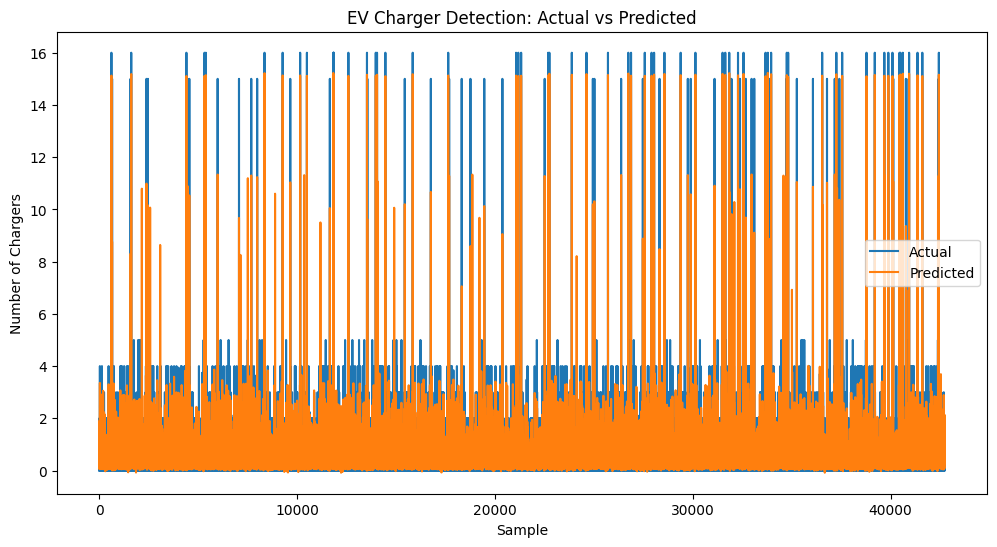

In [14]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.title('EV Charger Detection: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Number of Chargers')
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


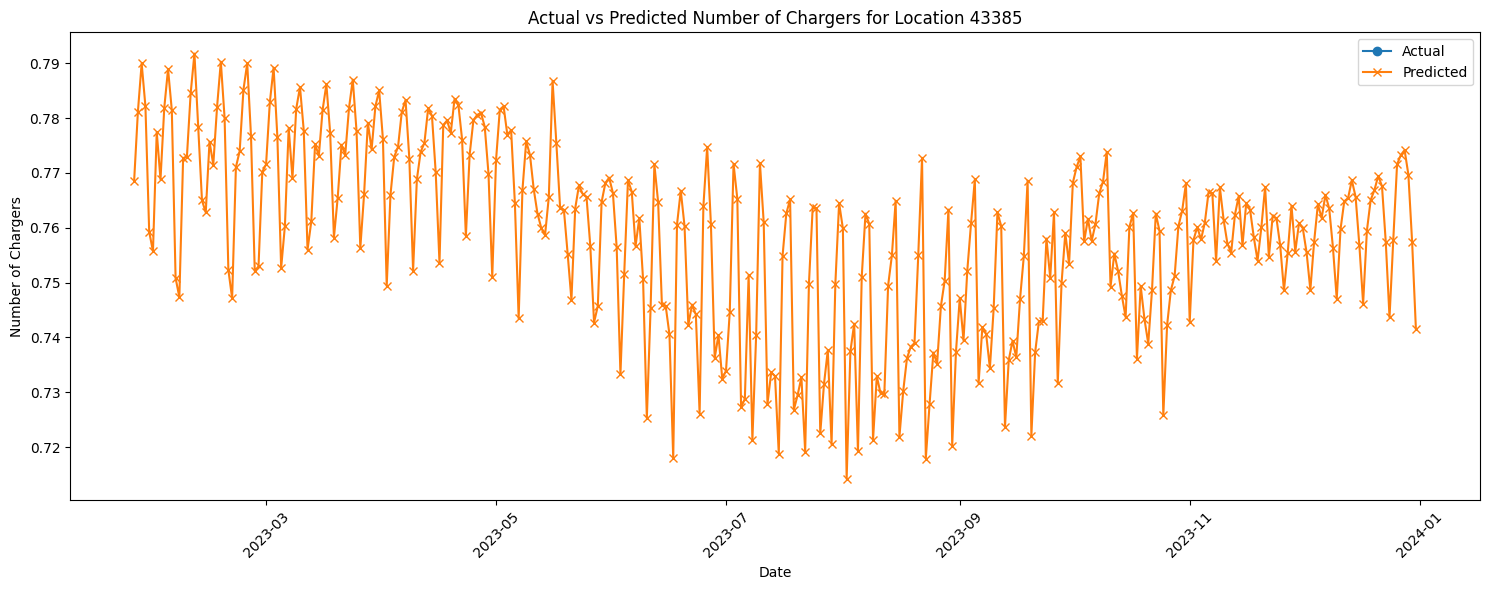

Mean Squared Error: nan
Mean Absolute Error: nan

Sample of predictions:
Date: 2023-01-25 00:00:00, Actual: nan, Predicted: 0.77
Date: 2023-01-26 00:00:00, Actual: nan, Predicted: 0.78
Date: 2023-01-27 00:00:00, Actual: nan, Predicted: 0.79
Date: 2023-01-28 00:00:00, Actual: nan, Predicted: 0.78
Date: 2023-01-29 00:00:00, Actual: nan, Predicted: 0.76
Date: 2023-01-30 00:00:00, Actual: nan, Predicted: 0.76
Date: 2023-01-31 00:00:00, Actual: nan, Predicted: 0.78
Date: 2023-02-01 00:00:00, Actual: nan, Predicted: 0.77
Date: 2023-02-02 00:00:00, Actual: nan, Predicted: 0.78
Date: 2023-02-03 00:00:00, Actual: nan, Predicted: 0.79


In [61]:
# Choose a specific location
chosen_location = 43385  # Replace with your desired location

# Filter data for the chosen location
location_data = combined_data[combined_data['Location'] == chosen_location].sort_values('YYYYMMDD')

# Prepare sequences for the entire location data
X_location = []
y_location = []
for i in range(len(location_data) - sequence_length):
    X_location.append(location_data.iloc[i:(i + sequence_length)][feature_columns].values)
    y_location.append(location_data.iloc[i + sequence_length]['# of Chargers'])

X_location = np.array(X_location)
y_location = np.array(y_location)

# Make predictions
if len(X_location) > 0:
    predictions = model.predict(X_location)

    # Prepare data for plotting
    dates = location_data.iloc[sequence_length:]['YYYYMMDD']
    actual_values = y_location

    # If you normalized the target variable, inverse transform the predictions and actual values
    if 'target_scaler' in globals():
        predictions = target_scaler.inverse_transform(predictions)
        actual_values = target_scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    # Plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_values, label='Actual', marker='o')
    plt.plot(dates, predictions, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Number of Chargers for Location {chosen_location}')
    plt.xlabel('Date')
    plt.ylabel('Number of Chargers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print some statistics
    mse = np.mean((actual_values - predictions.flatten())**2)
    mae = np.mean(np.abs(actual_values - predictions.flatten()))
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    # Display a sample of the predictions
    print("\nSample of predictions:")
    sample_size = min(10, len(dates))  # Display up to 10 samples
    for i in range(sample_size):
        print(f"Date: {dates.iloc[i]}, Actual: {actual_values[i]:.2f}, Predicted: {predictions[i][0]:.2f}")
else:
    print(f"Not enough data for location {chosen_location} to make predictions.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


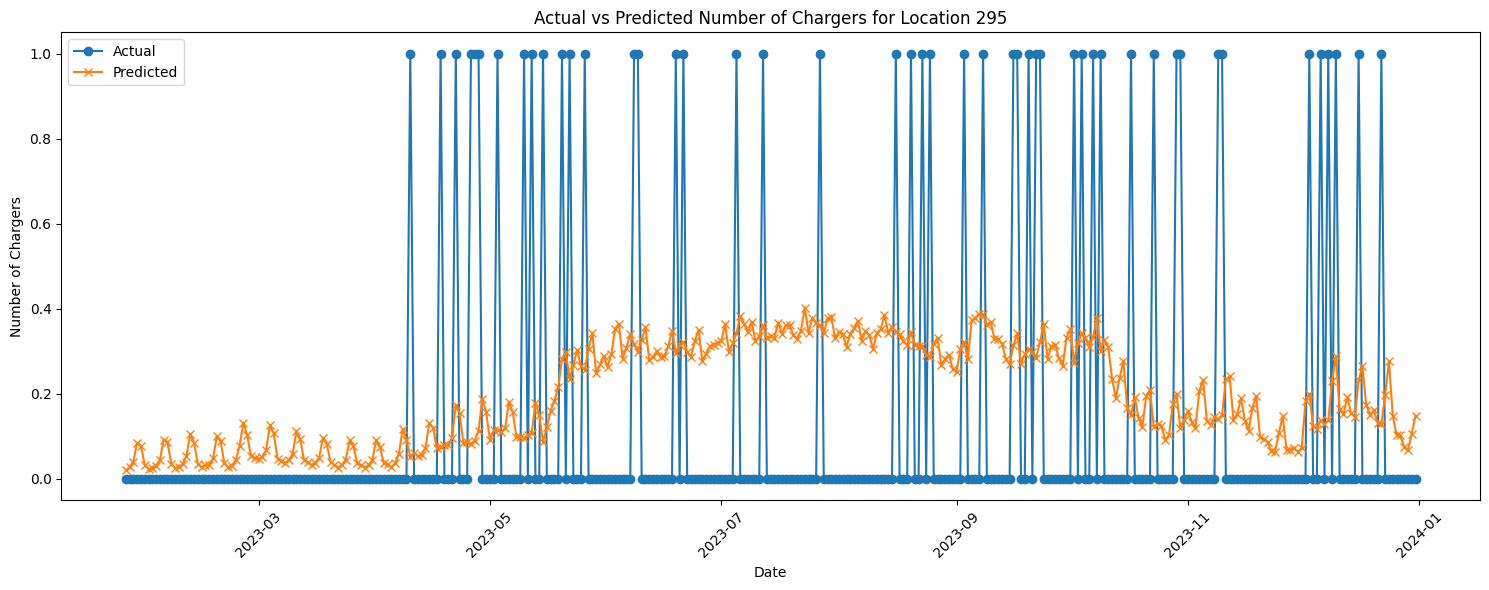

Mean Squared Error: 0.1274
Mean Absolute Error: 0.2726

Sample of predictions:
Date: 2023-01-25 00:00:00, Actual: 0.00, Predicted: 0.02
Date: 2023-01-26 00:00:00, Actual: 0.00, Predicted: 0.03
Date: 2023-01-27 00:00:00, Actual: 0.00, Predicted: 0.04
Date: 2023-01-28 00:00:00, Actual: 0.00, Predicted: 0.09
Date: 2023-01-29 00:00:00, Actual: 0.00, Predicted: 0.08
Date: 2023-01-30 00:00:00, Actual: 0.00, Predicted: 0.03
Date: 2023-01-31 00:00:00, Actual: 0.00, Predicted: 0.02
Date: 2023-02-01 00:00:00, Actual: 0.00, Predicted: 0.02
Date: 2023-02-02 00:00:00, Actual: 0.00, Predicted: 0.03
Date: 2023-02-03 00:00:00, Actual: 0.00, Predicted: 0.04


In [27]:
# Choose a specific location
chosen_location = 295  # Replace with your desired location

# Filter data for the chosen location
location_data = combined_data[combined_data['Location'] == chosen_location].sort_values('YYYYMMDD')

# Prepare sequences for the entire location data
X_location = []
y_location = []
for i in range(len(location_data) - sequence_length):
    X_location.append(location_data.iloc[i:(i + sequence_length)][feature_columns].values)
    y_location.append(location_data.iloc[i + sequence_length]['# of Chargers'])

X_location = np.array(X_location)
y_location = np.array(y_location)

# Make predictions
if len(X_location) > 0:
    predictions = model.predict(X_location)

    # Prepare data for plotting
    dates = location_data.iloc[sequence_length:]['YYYYMMDD']
    actual_values = y_location

    # If you normalized the target variable, inverse transform the predictions and actual values
    if 'target_scaler' in globals():
        predictions = target_scaler.inverse_transform(predictions)
        actual_values = target_scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    # Plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_values, label='Actual', marker='o')
    plt.plot(dates, predictions, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Number of Chargers for Location {chosen_location}')
    plt.xlabel('Date')
    plt.ylabel('Number of Chargers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print some statistics
    mse = np.mean((actual_values - predictions.flatten())**2)
    mae = np.mean(np.abs(actual_values - predictions.flatten()))
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    # Display a sample of the predictions
    print("\nSample of predictions:")
    sample_size = min(10, len(dates))  # Display up to 10 samples
    for i in range(sample_size):
        print(f"Date: {dates.iloc[i]}, Actual: {actual_values[i]:.2f}, Predicted: {predictions[i][0]:.2f}")
else:
    print(f"Not enough data for location {chosen_location} to make predictions.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
For location 30033:
Percentage of original data with value 1: 71.26%
Percentage of predictions with value > 0.5: 99.41%

Additional Statistics:
Mean of original data: 0.71
Mean of predictions: 0.68
Median of original data: 1.00
Median of predictions: 0.69


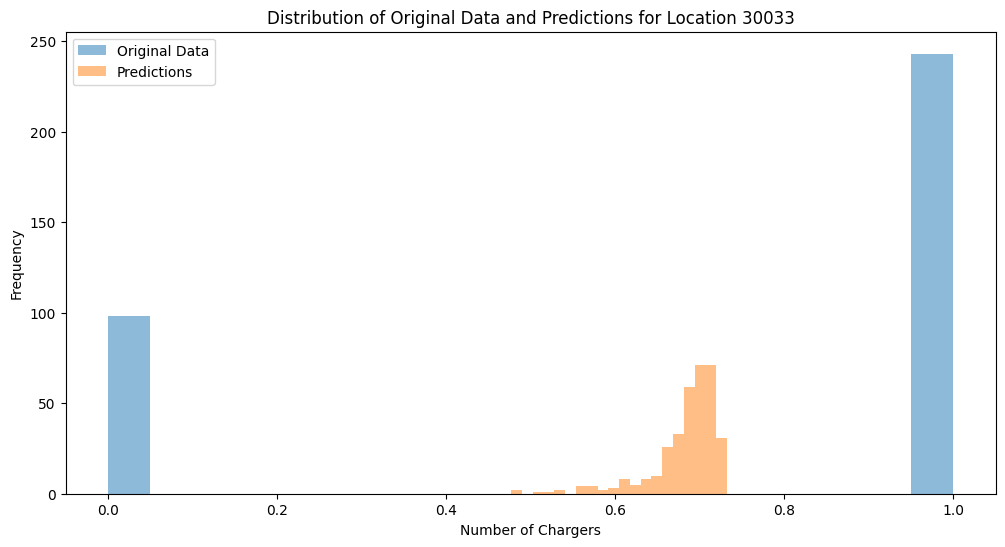

In [40]:
# Choose a specific location
chosen_location = 30033  # Replace with your desired location

# Filter data for the chosen location
location_data = combined_data[combined_data['Location'] == chosen_location].sort_values('YYYYMMDD')

# Prepare sequences for the entire location data
X_location = []
y_location = []
for i in range(len(location_data) - sequence_length):
    X_location.append(location_data.iloc[i:(i + sequence_length)][feature_columns].values)
    y_location.append(location_data.iloc[i + sequence_length]['# of Chargers'])

X_location = np.array(X_location)
y_location = np.array(y_location)

# Make predictions
if len(X_location) > 0:
    predictions = model.predict(X_location)

    # If you normalized the target variable, inverse transform the predictions and actual values
    if 'target_scaler' in globals():
        predictions = target_scaler.inverse_transform(predictions)
        y_location = target_scaler.inverse_transform(y_location.reshape(-1, 1)).flatten()

    # Calculate percentages
    original_percentage = np.mean(y_location == 1) * 100
    prediction_percentage = np.mean(predictions > 0.5) * 100

    print(f"For location {chosen_location}:")
    print(f"Percentage of original data with value 1: {original_percentage:.2f}%")
    print(f"Percentage of predictions with value > 0.5: {prediction_percentage:.2f}%")

    # Additional statistics
    print(f"\nAdditional Statistics:")
    print(f"Mean of original data: {np.mean(y_location):.2f}")
    print(f"Mean of predictions: {np.mean(predictions):.2f}")
    print(f"Median of original data: {np.median(y_location):.2f}")
    print(f"Median of predictions: {np.median(predictions):.2f}")

    # Visualize the distribution
    plt.figure(figsize=(12, 6))
    plt.hist(y_location, bins=20, alpha=0.5, label='Original Data')
    plt.hist(predictions, bins=20, alpha=0.5, label='Predictions')
    plt.title(f'Distribution of Original Data and Predictions for Location {chosen_location}')
    plt.xlabel('Number of Chargers')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

else:
    print(f"Not enough data for location {chosen_location} to make predictions.")

Preparing data: 100%|████████████████████████████████████████████████████████████████| 142/142 [01:30<00:00,  1.58it/s]


Making predictions...
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step


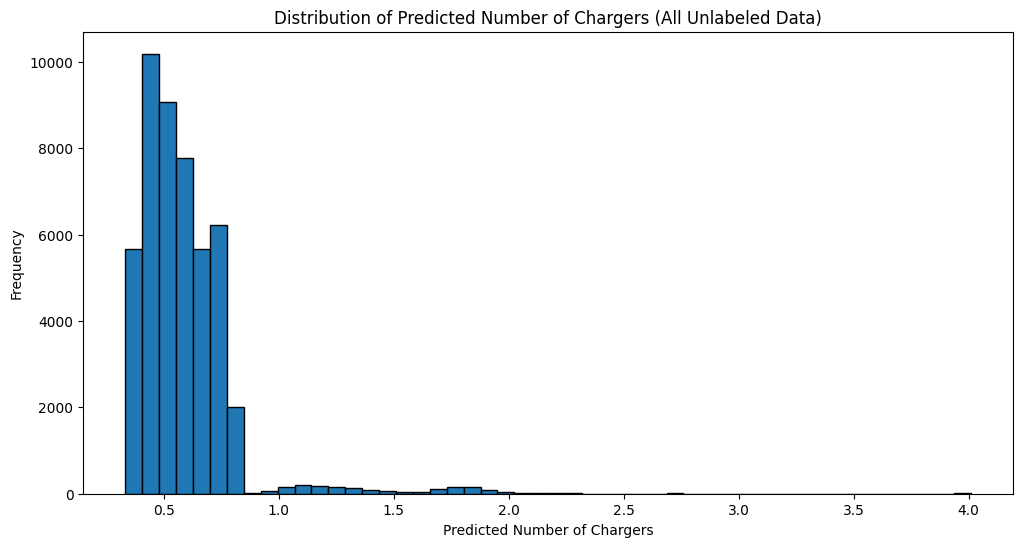

<Figure size 1500x800 with 0 Axes>

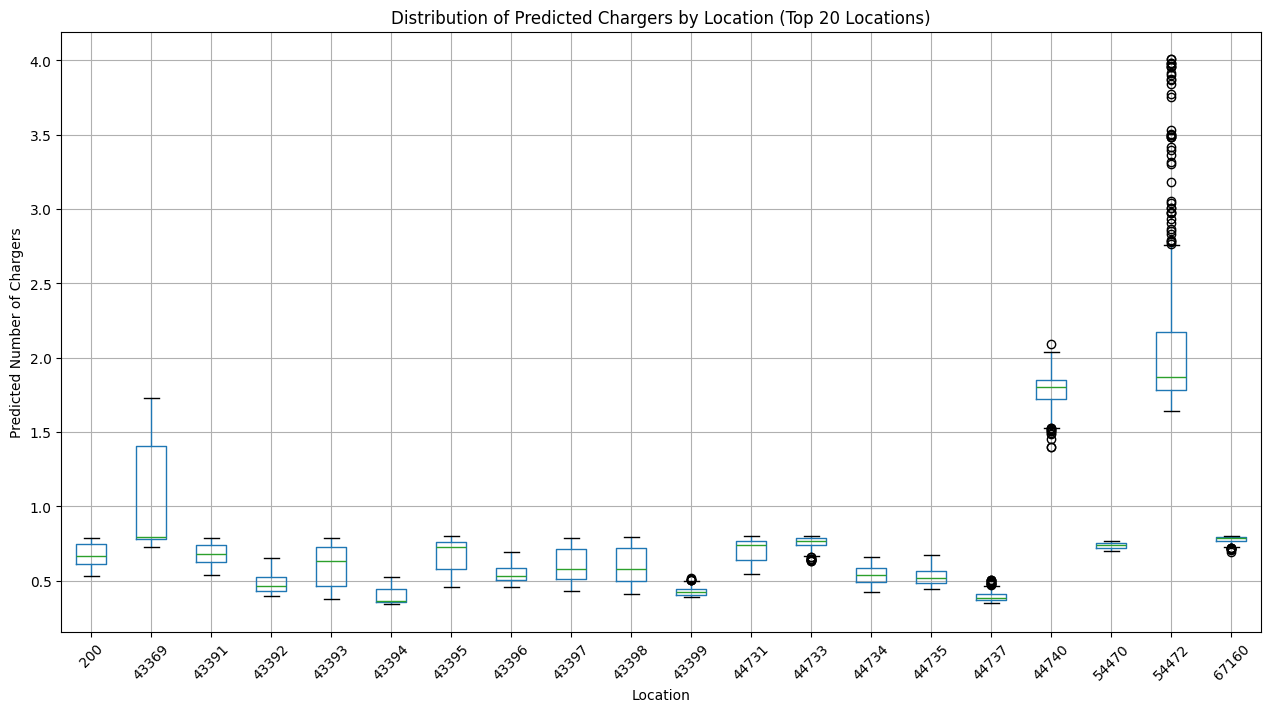

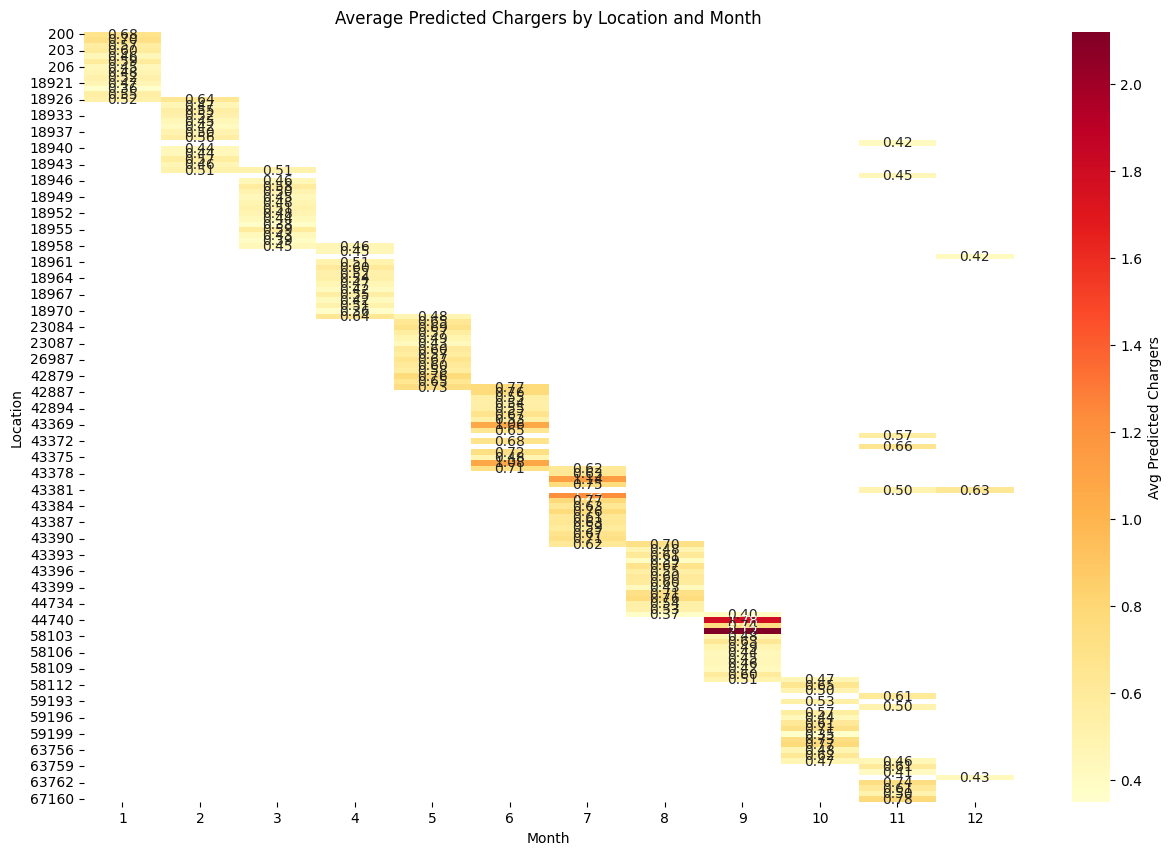

In [58]:
# Identify unlabeled data
unlabeled_data = combined_data[combined_data['# of Chargers'].isnull()]

# Prepare sequences for prediction
sequence_length = 24  # Adjust this if you used a different sequence length
X_unlabeled = []
locations = []

for location in tqdm(unlabeled_data['Location'].unique(), desc="Preparing data"):
    location_data = combined_data[combined_data['Location'] == location].sort_values('YYYYMMDD')
    for i in range(len(location_data) - sequence_length):
        if pd.isnull(location_data.iloc[i + sequence_length]['# of Chargers']):
            X_unlabeled.append(location_data.iloc[i:(i + sequence_length)][feature_columns].values)
            locations.append(location)

X_unlabeled = np.array(X_unlabeled)
locations = np.array(locations)

# Make predictions
print("Making predictions...")
predictions = model.predict(X_unlabeled)

# If you normalized the target variable, inverse transform the predictions
if 'target_scaler' in globals():
    predictions = target_scaler.inverse_transform(predictions)

# Create a DataFrame with predictions and corresponding locations
results_df = pd.DataFrame({
    'Location': locations,
    'Predicted_Chargers': predictions.flatten()
})

# Visualizations

# 1. Overall distribution of predictions
plt.figure(figsize=(12, 6))
plt.hist(results_df['Predicted_Chargers'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Number of Chargers (All Unlabeled Data)')
plt.xlabel('Predicted Number of Chargers')
plt.ylabel('Frequency')
plt.show()

# 2. Box plot of predictions by location (top 20 locations by data volume)
top_locations = results_df['Location'].value_counts().nlargest(20).index
location_data = results_df[results_df['Location'].isin(top_locations)]
plt.figure(figsize=(15, 8))
location_data.boxplot(column='Predicted_Chargers', by='Location', figsize=(15, 8))
plt.title('Distribution of Predicted Chargers by Location (Top 20 Locations)')
plt.suptitle('')  # This removes the automatic suptitle added by pandas
plt.ylabel('Predicted Number of Chargers')
plt.xticks(rotation=45)
plt.show()

# 3. Heatmap of average predictions by location and month
results_df['Month'] = pd.to_datetime(unlabeled_data['YYYYMMDD']).dt.month
heatmap_data = results_df.groupby(['Location', 'Month'])['Predicted_Chargers'].mean().unstack()
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Avg Predicted Chargers'})
plt.title('Average Predicted Chargers by Location and Month')
plt.ylabel('Location')
plt.xlabel('Month')
plt.show()




In [57]:
# Print some statistics
print("\nOverall Statistics:")
print(f"Total predictions made: {len(results_df)}")
print(f"Mean predicted chargers: {results_df['Predicted_Chargers'].mean():.2f}")
print(f"Median predicted chargers: {results_df['Predicted_Chargers'].median():.2f}")
print(f"Percentage of predictions > 0.50: {(results_df['Predicted_Chargers'] > 0.5).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.60: {(results_df['Predicted_Chargers'] > 0.65).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.75: {(results_df['Predicted_Chargers'] > 0.75).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.76: {(results_df['Predicted_Chargers'] > 0.76).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.77: {(results_df['Predicted_Chargers'] > 0.77).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.78: {(results_df['Predicted_Chargers'] > 0.78).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.79: {(results_df['Predicted_Chargers'] > 0.79).mean() * 100:.2f}%")
print(f"Percentage of predictions > 0.80: {(results_df['Predicted_Chargers'] > 0.8).mean() * 100:.2f}%")

# Top 5 locations with highest average predicted chargers
top_5_avg = results_df.groupby('Location')['Predicted_Chargers'].mean().nlargest(5)
print("\nTop 5 Locations with Highest Average Predicted Chargers:")
print(top_5_avg)

# Bottom 5 locations with lowest average predicted chargers
bottom_5_avg = results_df.groupby('Location')['Predicted_Chargers'].mean().nsmallest(5)
print("\nBottom 5 Locations with Lowest Average Predicted Chargers:")
print(bottom_5_avg)


Overall Statistics:
Total predictions made: 48424
Mean predicted chargers: 0.59
Median predicted chargers: 0.55
Percentage of predictions > 0.50: 62.06%
Percentage of predictions > 0.60: 28.48%
Percentage of predictions > 0.75: 12.55%
Percentage of predictions > 0.76: 10.54%
Percentage of predictions > 0.77: 8.68%
Percentage of predictions > 0.78: 7.17%
Percentage of predictions > 0.79: 5.57%
Percentage of predictions > 0.80: 4.11%

Top 5 Locations with Highest Average Predicted Chargers:
Location
54472    2.119991
44740    1.781147
43382    1.230759
43379    1.135927
43376    1.081885
Name: Predicted_Chargers, dtype: float32

Bottom 5 Locations with Lowest Average Predicted Chargers:
Location
59199    0.349665
18922    0.355053
18970    0.356955
18954    0.375012
18957    0.390339
Name: Predicted_Chargers, dtype: float32


Top 20 locations by percentage of predictions over 0.7:
          Predicted_Chargers_total_predictions  \
Location                                         
43385                                      341   
43369                                      342   
43379                                      341   
54472                                      341   
54470                                      341   
44740                                      341   
43382                                      341   
43383                                      341   
67160                                      342   
63755                                      341   
43376                                      341   
42879                                      341   
42887                                      341   
44733                                      341   
43380                                      341   
63762                                      341   
59201                                      3

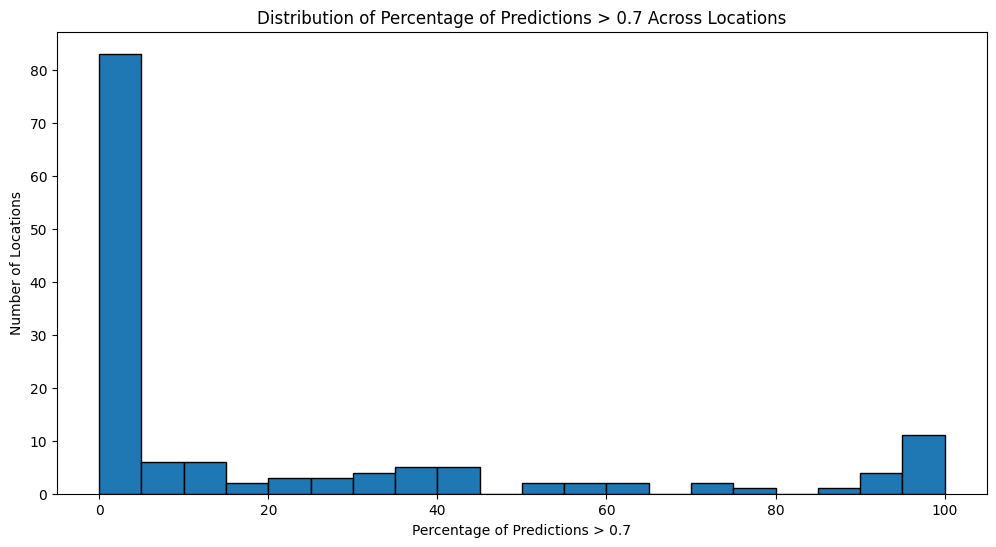

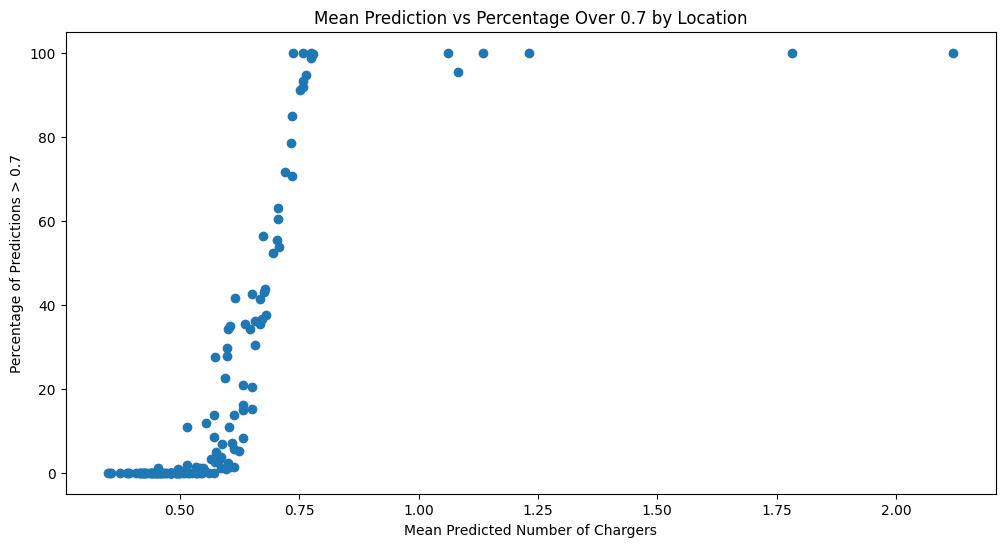


Detailed statistics saved to 'location_prediction_stats_0.7_threshold.csv'


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'results_df' is your DataFrame with predictions
# It should have columns: 'Location' and 'Predicted_Chargers'

# Calculate percentage of predictions > 0.7 for each location
location_stats = results_df.groupby('Location').agg({
    'Predicted_Chargers': [
        ('total_predictions', 'count'),
        ('mean_prediction', 'mean'),
        ('median_prediction', 'median'),
        ('percentage_over_0.7', lambda x: (x > 0.7).mean() * 100)
    ]
})

# Flatten column names
location_stats.columns = ['_'.join(col).strip() for col in location_stats.columns.values]

# Sort by percentage_over_0.7 in descending order
location_stats = location_stats.sort_values('Predicted_Chargers_percentage_over_0.7', ascending=False)

# Display the top 20 locations
print("Top 20 locations by percentage of predictions over 0.7:")
print(location_stats.head(20))

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total number of locations: {len(location_stats)}")
print(f"Mean percentage over 0.7 across all locations: {location_stats['Predicted_Chargers_percentage_over_0.7'].mean():.2f}%")
print(f"Median percentage over 0.7 across all locations: {location_stats['Predicted_Chargers_percentage_over_0.7'].median():.2f}%")
print(f"Locations with >35% predictions above 0.7: {(location_stats['Predicted_Chargers_percentage_over_0.7'] > 30).sum()}")
print(f"Locations with <35% predictions above 0.7: {(location_stats['Predicted_Chargers_percentage_over_0.7'] <= 30).sum()}")

# Visualize the distribution of percentages
plt.figure(figsize=(12, 6))
plt.hist(location_stats['Predicted_Chargers_percentage_over_0.7'], bins=20, edgecolor='black')
plt.title('Distribution of Percentage of Predictions > 0.7 Across Locations')
plt.xlabel('Percentage of Predictions > 0.7')
plt.ylabel('Number of Locations')
plt.show()

# Scatter plot of mean prediction vs percentage over 0.7
plt.figure(figsize=(12, 6))
plt.scatter(location_stats['Predicted_Chargers_mean_prediction'], 
            location_stats['Predicted_Chargers_percentage_over_0.7'])
plt.title('Mean Prediction vs Percentage Over 0.7 by Location')
plt.xlabel('Mean Predicted Number of Chargers')
plt.ylabel('Percentage of Predictions > 0.7')
plt.show()

# Save the results to a CSV file
location_stats.to_csv('location_prediction_stats_0.7_threshold.csv')
print("\nDetailed statistics saved to 'location_prediction_stats_0.7_threshold.csv'")